- Limpiar la data de valores nulos
- Ver si podemos aplicar el target encoding (y resumir más la dummies)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as no
import seaborn as sns
import missingno as msno
import gc
gc.collect() #Como garbage cleaner
df = pd.read_csv('data_pseudo_limpia.csv')
pd.set_option('display.max_columns',None) #Para ver todas mis columnas...

In [12]:
cols = df.columns
print(*cols)

Unnamed: 0 Antiguedad Anunciante Area_Terreno Balneario NroBanios Nro_pisos Cocheras Descripcion Direccion Disposicion Dormitorios Estado de Inmueble Fecha_pub Fila Fondo Frente Luminosidad Mantenimiento Mascotas Medidas Pisos_construibles TipoPuertaCochera Precio Referencia Tipo TipoCochera Ubicacion SinNombre Urbaniz Uso_comercial Uso_profesional Area_constr Area_total Area_constr_m2 Area_total_m2 Area_Terreno_m2 match 'Balcon' 'Deposito' 'Escritorio' 'Banio de visitas' 'Terraza' 'Banio independiente' 'anx81tico' 'Comedor diario' 'Kitchenette' 'Jardanxadn Interno' 'Banio de servicio' 'Patio' 'Cocina' 'Comedor' 'Sotano' 'Lavanderanxada' 'Sala de estar' 'Closet' 'Cuarto de servicio' 'Walking Closet' 'Sala' 'Conexion a gas' 'Servicio de Limpieza' 'Sistema de seguridad' 'Guardiananxada' 'Internet' 'Telefono' 'Agua' 'Cable' 'Luz' 'Hall de ingreso' 'anx81reas verdes' 'Guarderanxada' 'Juegos para ninios' 'Sala de cine' 'Jardanxadn' 'Gimnasio' 'Sala de internet' 'Areade BBQ' 'Solarium' 'Parq

In [2]:
#Eliminaré las variables que no tienen data en sí.
df.drop(['EsCondominio'], inplace = True, axis=1)
df.drop(['NoTieneAlgunDatoExtra'],inplace=True,axis=1)

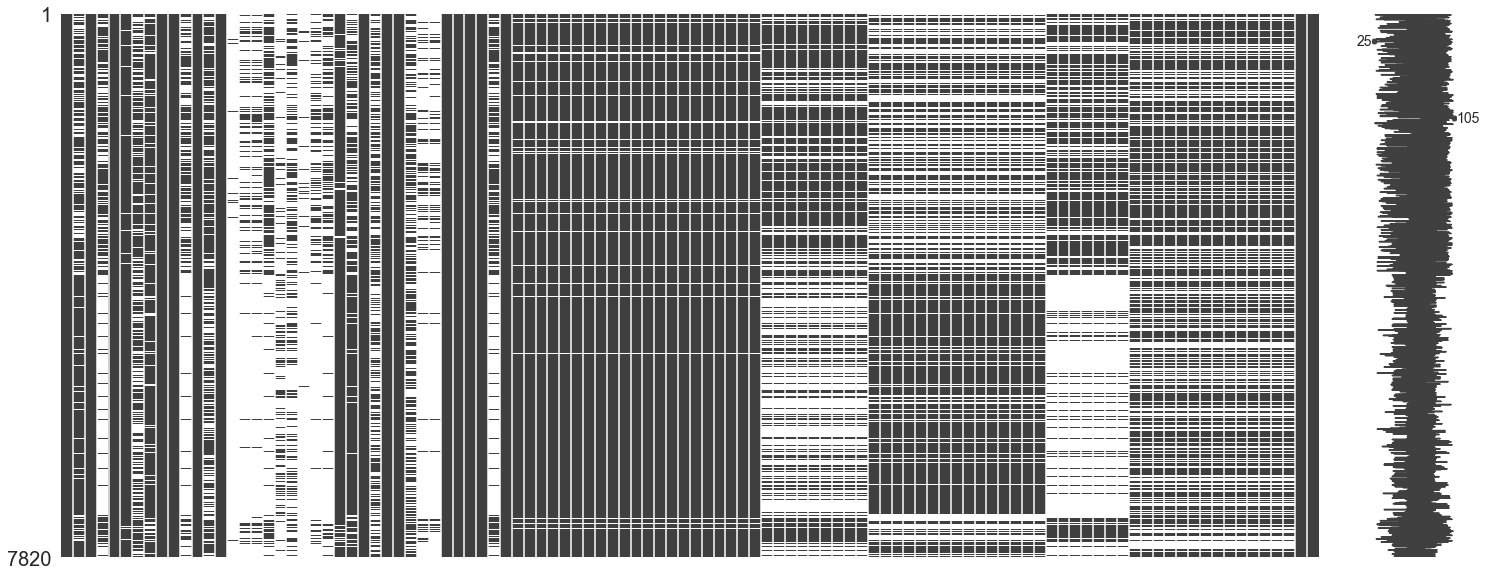

In [11]:
sns.set(style='whitegrid')
msno.matrix(df)

La variable "Balneario" nos dice en qué balneario está nuestra CASA DE PLAYA. Por lo tanto, revisaré si es que todas las casas de Playa tienen esta variable. Sino, reemplazo esos nulos por un "NoEspecifica". Y las casas normales las cambiaré por "NoEsCasaPlaya"  

In [5]:
#Reemplazo los valores nulos de Balneario
df.loc[(df['Balneario'].isna()) & (df['Tipo'] == 'Casa de Playa'),'Balneario'] = 'NoEspecifica'
df.loc[(df['Balneario'].isna()),'Balneario'] = 'Nulo'

Ahora, analizaremos la variable Antiguedad:

In [13]:
df.Antiguedad.isna().sum()

1842

In [15]:
df.Antiguedad.unique()

array([ 3.,  5.,  2., nan,  4.,  6.,  7.,  1.,  8.,  9.])

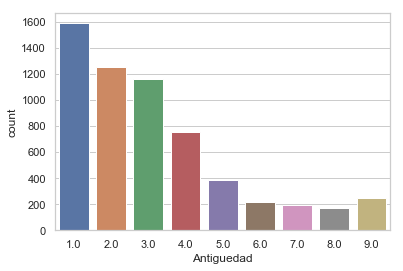

In [14]:
sns.countplot(x='Antiguedad',data=df)

In [82]:
df.drop(['match','Area_constr','Area_total','Unnamed:0','Fila'],axis=1,inplace=True)

KeyError: "['match' 'Area_constr' 'Area_total' 'Unnamed:0'] not found in axis"

In [31]:
df[((df['\'Piscina\''] == 1)&(df['Distrito'] == 'LaMolina'))]

,Unnamed: 0,Antiguedad,Anunciante,Area_Terreno,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,SinNombre,Urbaniz,Uso_comercial,Uso_profesional,Area_constr,Area_total,Area_constr_m2,Area_total_m2,Area_Terreno_m2,match,'Balcon','Deposito','Escritorio','Banio de visitas','Terraza','Banio independiente','anx81tico','Comedor diario','Kitchenette','Jardanxadn Interno','Banio de servicio','Patio','Cocina','Comedor','Sotano','Lavanderanxada','Sala de estar','Closet','Cuarto de servicio','Walking Closet','Sala','Conexion a gas','Servicio de Limpieza','Sistema de seguridad','Guardiananxada','Internet','Telefono','Agua','Cable','Luz','Hall de ingreso','anx81reas verdes','Guarderanxada','Juegos para ninios','Sala de cine','Jardanxadn','Gimnasio','Sala de internet','Areade BBQ','Solarium','Parque interno','Areade sauna','Club House','Piscina','Areadeportiva','Colegios cercanos','Parques cercanos','Centros comerciales cercanos','Cerca al mar','Acceso personas discapacidad','Ingreso independiente','Frente al mar','Intercomunicador','Portero electrico','Calefaccion','Jacuzzi','Chimenea','Desagaue','Aire acondicionado','Sauna','Amoblado','Cerco Electrico','Cocina con reposteros','Parrilla','Terma','Equipado',Distrito,Provincia
27,30,2.0,MIRYAN SAAVEDRA,NaN,Nulo,4.0,2.0,3.0,Linda casa de dos pisos con opciÃ³n a 4 dormi...,"A Dos Cuadras De La Laguna La Molina, Las Lagu...",NaN,3,Muy bueno,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600000.0,A DOS CUADRAS DE LA LAGUNA,Casa,Paralelas,LaMolina-Lima,Casa1024,Las Lagunas De La Molina,NaN,NaN,400.00 m2,500.00 m2,400.0,500.0,NaN,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,LaMolina,Lima
35,38,2.0,INMOBILIARIA EXCLUSVE,800.00 m2,Nulo,3.0,3.0,2.0,Linda casa de 800 m2 en Rinconada del Lago co...,"Calle Lagonave 200, Rinconada, La Molina La Mo...",Esquina,4,Muy bueno,Publicado el 25.08.19,NaN,40.0,20.0,Luminoso,NaN,NaN,NaN,NaN,Manual,680000.0,NaN,Casa,Separadas,LaMolina-Lima,Casa1031,Rinconada Del Lago,NaN,NaN,800.00 m2,800.00 m2,800.0,800.0,800.0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,LaMolina,Lima
43,46,NaN,ALFREDO VARGAS,1300.00 m2,Nulo,5.0,NaN,4.0,"T. ver datos CASA EN LA PLANICIE, EN TRES N...","La Molina, La Planicie, Lima, Lima",Frente,5+,NaN,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1090000.0,NaN,Casa,NaN,LaMolina-Lima,Casa1039,La Planicie,NaN,NaN,450.00 m2,NaN,450.0,NaN,1300.0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LaMolina,Lima
46,49,NaN,ALFREDO VARGAS,1300.00 m2,Nulo,5.0,NaN,4.0,T. ver datos ver datos LA PLANICIE PASANDO...,"La Molina, La Planicie, Lima, Lima",Frente,5+,NaN,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1090000.0,NaN,Casa,NaN,LaMolina-Lima,Casa1041,La Planicie,NaN,NaN,460.00 m2,NaN,460.0,NaN,1300.0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LaMolina,Lima
59,65,6.0,Alfredo Graf & Asociados - Agentes Inmobiliarios,1311.00 m2,Nulo,5.0,NaN,5.0,Casa en vent

In [77]:
#Voy a reemplazar para como esquina...  
df[df['Descripcion'].str.contains('esquina')]

,Unnamed: 0,Antiguedad,Anunciante,Area_Terreno,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,SinNombre,Urbaniz,Uso_comercial,Uso_profesional,Area_constr_m2,Area_total_m2,Area_Terreno_m2,'Balcon','Deposito','Escritorio','Banio de visitas','Terraza','Banio independiente','anx81tico','Comedor diario','Kitchenette','Jardanxadn Interno','Banio de servicio','Patio','Cocina','Comedor','Sotano','Lavanderanxada','Sala de estar','Closet','Cuarto de servicio','Walking Closet','Sala','Conexion a gas','Servicio de Limpieza','Sistema de seguridad','Guardiananxada','Internet','Telefono','Agua','Cable','Luz','Hall de ingreso','anx81reas verdes','Guarderanxada','Juegos para ninios','Sala de cine','Jardanxadn','Gimnasio','Sala de internet','Areade BBQ','Solarium','Parque interno','Areade sauna','Club House','Piscina','Areadeportiva','Colegios cercanos','Parques cercanos','Centros comerciales cercanos','Cerca al mar','Acceso personas discapacidad','Ingreso independiente','Frente al mar','Intercomunicador','Portero electrico','Calefaccion','Jacuzzi','Chimenea','Desagaue','Aire acondicionado','Sauna','Amoblado','Cerco Electrico','Cocina con reposteros','Parrilla','Terma','Equipado',Distrito,Provincia
2,3,2.0,Century 21 Capital,NaN,Nulo,4.0,NaN,NaN,Venta de amplia Casa en estupenda zona de Mir...,Av. Diez Canseco Cerca A Parque Tradiciones// ...,NaN,5+,NaN,Publicado el 24.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,649000.0,A poca caudra de Av. Ricardo Palma,Casa,NaN,Miraflores-Lima,Casa100,NaN,NaN,NaN,215.0,215.0,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Miraflores,Lima
40,43,4.0,CALDERON JOSE LUIS,294.00 m2,Nulo,3.0,2.0,3.0,Casa ubicada en esquina con (tres frentes) u...,"Calle Augusto Gutierrez Cuadra 1 Miraflores, A...",Frente,4,Bueno,Publicado el 25.08.19,NaN,21.0,14.0,Luminoso,NaN,Si,NaN,2.0,Manual,585000.0,Una cuadra del colegio von humboldt,Casa,Paralelas,Miraflores-Lima,Casa1036,Alexander Von Humboldt,NaN,NaN,250.0,294.0,294.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Miraflores,Lima
42,45,4.0,CALDERON JOSE LUIS,294.00 m2,Nulo,5.0,2.0,2.0,Casa ubicada en esquina con una excelente ubi...,"Calle Augusto Gutierrez Miraflores, Alexander ...",Frente,4,A Remodelar,Publicado el 25.08.19,NaN,21.0,14.0,Muy luminoso,NaN,Si,NaN,2.0,Manual,585000.0,UNA CUADRA DE COLEGIO A VON HUMBOLDT,Casa,Paralelas,Miraflores-Lima,Casa1038,Alexander Von Humboldt,NaN,NaN,250.0,294.0,294.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Miraflores,Lima
94,118,NaN,Big Fish Realty,601.00 m2,Nulo,5.0,3.0,4.0,La Zona: UbicaciÃ³n exclusiva (esquina) en mu...,"Orrantia Del Mar San Isidro, Lima, Lima",NaN,5+,A Remodelar,Publicado el 24.08.19,NaN,32.0,18.0,Muy luminoso,NaN,Si,NaN,4.0,NaN,1420000.0,Parque 'La Pera',Casa,NaN,SanIsidro-Lima,Casa1103,NaN,NaN,NaN,800.0,601.0,601.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,SanIsidro,Lima
117,147,NaN,PROIN SAC,NaN,Nulo,5.0,NaN,5.0,CÃ³digo: CV. ver datos \r\r\r

In [16]:
for i in df.columns:
    if df[i].isna().any():
        print('La columna', i, 'tiene', df[i].isna().sum())

La columna Antiguedad tiene 1842
La columna Area_Terreno tiene 4825
La columna NroBanios tiene 229
La columna Nro_pisos tiene 3236
La columna Cocheras tiene 1083
La columna Disposicion tiene 5580
La columna Estado de Inmueble tiene 2699
La columna Fila tiene 7693
La columna Fondo tiene 6663
La columna Frente tiene 6522
La columna Luminosidad tiene 4893
La columna Mantenimiento tiene 6552
La columna Mascotas tiene 5240
La columna Medidas tiene 7618
La columna Pisos_construibles tiene 6302
La columna TipoPuertaCochera tiene 5960
La columna Precio tiene 228
La columna Referencia tiene 1847
La columna TipoCochera tiene 4108
La columna Urbaniz tiene 3442
La columna Uso_comercial tiene 6851
La columna Uso_profesional tiene 6882
La columna Area_constr tiene 8
La columna Area_total tiene 6
La columna Area_constr_m2 tiene 8
La columna Area_total_m2 tiene 6
La columna Area_Terreno_m2 tiene 4825
La columna 'Balcon' tiene 404
La columna 'Deposito' tiene 404
La columna 'Escritorio' tiene 404
La col

In [40]:
for i in ['Frente', 'Esquina', 'Contrafrente', 'Interno', 'Lateral']:
    print(df['Disposicion'].str.contains(i).sum())

1829
246
28
105
32


In [41]:
df['Balneario'].unique()

array([nan, 'Colan', 'Punta Negra', 'SeÃ\x91oritas', 'Las Arenas',
       'Cocoa', 'Sarapampa', 'Punta Corrientes', 'Asia', 'Coral',
       'Lomas De Mar', 'Arica', 'Las Palmas', 'El Mirador', 'Misterio',
       'Boca De Leon', 'Chocalla', 'La Jolla', 'Del Sol', 'Pulpos',
       'Punta Hermosa', 'El Golf', 'Las Gramas', 'Puerto Nuevo',
       'Pelicanos', 'Zorritos', 'Asia Del Mar', 'Country Club De Villa',
       'La Encantada', 'Palabritas', 'Lobo Blanco', 'Pucusana',
       'Costa Del Sol', 'Chapecoane', 'Puerto Fiel', 'La Encontrada',
       'El Barrancadero', 'Moravia', 'Las Palmeras', 'Asia Del Sol',
       'Minkamar', 'Honda', 'San Bartolo', 'Las Gaviotas', 'Cerro Azul',
       'Villa', 'Mar Adentro', 'Paracas', 'Asia Del Sur', 'Lobos',
       'San Pedro', 'Balneario De Ancon', 'Rivera Norte', 'Mejia',
       'El Silencio', 'Las Brisas', 'Pocitas', 'Caballeros', 'Paraiso',
       'Punta Roca', 'Las Brisas De Villa', 'Blanca', 'Sol Y Mar',
       'Los Flamencos', 'Las Salinas', '